<div style="background-color:yellow; text-align:center; text-align:center; padding:40px;">
<h1  style="color:red;" > DI-725 : Transformers and Attention-Based Deep Networks </h1>   
<h2  style="color:red;" > Assignment - 2 </h2>
<br>
<br>
<h4  style="color:red;" >Turgay Yıldız</h4>
<br>
<h4  style="color:red;" >Graduate School of Informatics,  Middle East Technical University (METU)</h4>
</div>


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  First Import the Relevant Packages  </h2>
</div>

In [1]:
# @title Fetch big_vision code and install dependencies.
import os
import sys

In [2]:
# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

In [3]:
# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

In [4]:
# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

In [5]:
# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.7 MB/s eta 0:00:00


In [6]:
import os
from google.colab import userdata

In [13]:
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["KAGGLE_USERNAME"] =    'esmikcihyab'
os.environ["KAGGLE_KEY"]      =    '965138089c8edfebd198253d34694d62'

In [14]:
# The T4 runtime is tight on memory to finetune this model. Preallocate
# all memory ahead of time to avoid OOM'ing due to fragmentation.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

In [15]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import os
import kagglehub

In [17]:
# Use these for PaliGemma-2 3B 224px²
#LLM_VARIANT   = "gemma2_2b"
#MODEL_PATH    = "./paligemma2-3b-pt-224.b16.npz"
#KAGGLE_HANDLE = "google/paligemma-2/jax/paligemma2-3b-pt-224"  # Path to fetch from Kaggle.

In [19]:
# Use these for PaliGemma 1:
LLM_VARIANT   = "gemma_2b"
MODEL_PATH    = "./paligemma-3b-pt-224.f16.npz"
KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224"

In [20]:
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

Model path: /kaggle/input/paligemma/jax/paligemma-3b-pt-224/1/./paligemma-3b-pt-224.f16.npz


In [21]:
TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

Copying gs://big_vision/paligemma_tokenizer.model...
\ [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


In [22]:
DATA_DIR="./longcap100"
if not os.path.exists(DATA_DIR):
  print("Downloading the dataset...")
  !gsutil -m -q cp -n -r gs://longcap100/ .
  print(f"Data path: {DATA_DIR}")

Data path: ./longcap100


In [23]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.5.2
JAX platform: gpu
JAX devices:  1


In [24]:
# @title Construct model and load params into RAM.

# Define model
# IMPORTANT: Gemma-2 has a "final_logits_softcap" property, we set it to 0.0
# for better transfer results.
#model_config = ml_collections.FrozenConfigDict({
#    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
#    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
#})
#--------------------------------------------------------------------------------------------------------#
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})

In [25]:
model     = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

In [26]:
# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

In [27]:
# Define `decode` function to sample outputs from the model.
decode_fn  =   predict_fns.get_all(model)['decode']
decode     =   functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

In [28]:
# @title Move params to GPU/TPU memory.
#
# To keep HBM usage low and fit in a T4 GPU (16GB HBM) we opt to only finetune
# a part of the parameters. Additionally we keep the frozen params in float16
# and cast trainable to float32.

# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)


In [29]:
# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

In [30]:
data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

In [31]:
params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

In [32]:
# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

In [33]:
@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  # Cast others to float16, since some GPUs don't support bf16.
  return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                      if m else p.astype(jnp.float16),
                      params, trainable)

In [34]:
# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default (12GB RAM).
# Instead we do it param by param.
params, treedef  = jax.tree.flatten(params)
sharding_leaves  = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)

for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

In [35]:
# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")


In [36]:
print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

In [37]:
# @title Define preprocess functions to create inputs to the model.

def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if its a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [47]:
import os
import tensorflow as tf
import pandas as pd

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
os.listdir("/content/drive/MyDrive/extracted_folder")

['resized', 'captions.csv']

In [52]:
# 2. Paths & constants
DATA_DIR   = '/content/drive/MyDrive/extracted_folder/'
CSV_PATH   = os.path.join(DATA_DIR, 'captions.csv')
IMAGE_ROOT = os.path.join(DATA_DIR, 'resized')
BATCH_SIZE = 32
IMG_SIZE   = (224, 224)

In [53]:
# 3. Read the full CSV
#    Expect columns: "filename" (relative to IMAGE_ROOT), "label", "split" (train/validation/test)
df = pd.read_csv(CSV_PATH)

In [57]:
df.head()

,source,split,image,caption_1,caption_2,caption_3,caption_4,caption_5
0,NWPU,test,NWPU_31430.jpg,A gray plane on the runway and the lawn beside .,A grey plane is on the runway by the lawn .,There is an airplane on the runway with a larg...,A plane is parked on the runway next to the gr...,There is a plane on the runway beside the grass .
1,NWPU,test,NWPU_31431.jpg,Three small planes parked in a line on the air...,"There are four aircraft on the open ground, Th...",There are many planes of different sizes in a ...,Four planes are parked on the runway .,Four planes of different sizes were on the mar...
2,NWPU,test,NWPU_31432.jpg,A plane parked in a line on the airport with s...,A white plane was parked on the instruction li...,An airplane parked in an open area with many c...,A plane is parked on the open space .,There is 1 plane on the ground marked .
3,NWPU,test,NWPU_31433.jpg,A small plane and a big plane parked next to b...,A white plane and a gray plane parked at the b...,Two planes of different sizes are neatly parke...,A large plane and a small plane are parked nea...,Two planes are on the marked ground .
4,NWPU,test,NWPU_31434.jpg,Two planes parked next to boarding bridges .,Two aircraft were parked at the departure gates .,Two planes of different sizes are neatly parke...,Two planes are parked next to the terminal .,Two planes are on the marked ground .


In [59]:
df.columns

Index(['source', 'split', 'image', 'caption_1', 'caption_2', 'caption_3',
       'caption_4', 'caption_5'],
      dtype='object')

In [104]:
print("All split labels:", df['split'].unique())
print("Counts:\n", df['split'].value_counts())

All split labels: ['test' 'val' 'train']
Counts:
 split
train    35614
test      4454
val       4453
Name: count, dtype: int64


In [105]:
# 4. Filter into splits
splits = {}
for split_name in ['train', 'val', 'test']:
    splits[split_name] = df[df['split'] == split_name]

In [106]:
# 5. Convert each split-DataFrame into (paths, captions)
def df_to_paths_and_captions(split_df):
    # Full paths
    paths = split_df['image'].apply(lambda fn: os.path.join(IMAGE_ROOT, fn)).tolist()
    # List-of-captions per example
    captions_cols = [f'caption_{i}' for i in range(1,6)]
    captions = split_df[captions_cols].values.tolist()
    return paths, captions

In [107]:
train_paths, train_caps = df_to_paths_and_captions(splits['train'])
val_paths,   val_caps   = df_to_paths_and_captions(splits['val'])
test_paths,  test_caps  = df_to_paths_and_captions(splits['test'])

In [108]:
# 6. Preprocessing fn: load image + return captions list
def _load_and_preprocess(path, captions):
    # Read & decode
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    # Resize & normalize
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, captions

# 7. Build the tf.data pipeline
def make_dataset(paths, captions, shuffle=False):
    # turn your Python list-of-strings into a tf.string tensor
    paths_ds = tf.data.Dataset.from_tensor_slices(tf.constant(paths, dtype=tf.string))
    # turn your list-of-lists-of-strings into a [5] tf.string tensor
    caps_ds  = tf.data.Dataset.from_tensor_slices(tf.constant(captions, dtype=tf.string))

    ds = tf.data.Dataset.zip((paths_ds, caps_ds))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ( ds
           .map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE)
         )
    return ds

In [109]:
train_ds = make_dataset(train_paths, train_caps, shuffle=True)
val_ds   = make_dataset(val_paths,   val_caps,   shuffle=False)
test_ds  = make_dataset(test_paths,  test_caps,  shuffle=False)

In [112]:
# 8. Quick sanity check
for imgs, caps in test_ds.take(1):
    print("Images batch shape:", imgs.shape)            # (BATCH_SIZE, H, W, 3)
    print("Captions batch shape:", len(caps), "examples")
    print("First example captions:", caps[0])            # a list of 5 strings

Images batch shape: (8, 224, 224, 3)
Captions batch shape: 8 examples
First example captions: tf.Tensor(
[b'A gray plane on the runway and the lawn beside .'
 b'A grey plane is on the runway by the lawn .'
 b'There is an airplane on the runway with a large lawn by the runway .'
 b'A plane is parked on the runway next to the grass .'
 b'There is a plane on the runway beside the grass .'], shape=(5,), dtype=string)


In [113]:
# 1. Create two tf.string datasets
paths_ds = tf.data.Dataset.from_tensor_slices(
    tf.constant(train_paths, dtype=tf.string)
)
caps_ds = tf.data.Dataset.from_tensor_slices(
    tf.constant(train_caps, dtype=tf.string)
)

In [114]:
# 2. Zip them together
train_ds = tf.data.Dataset.zip((paths_ds, caps_ds))


In [115]:
# 3. Shuffle, map, batch, prefetch
def _load_and_preprocess(path, captions):
    # path: tf.string scalar
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    # captions: tf.Tensor shape=(5,), dtype=string
    # If you need Python strings later you can tf.strings.unicode_decode,
    # but most models expect tokenized strings as-is.
    return img, captions

In [116]:
train_ds = (
    train_ds
    .shuffle(buffer_size=len(train_paths))
    .map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [117]:
# 4. Sanity‐check iteration
for img_batch, cap_batch in train_ds.take(1):
    print("Image batch:", img_batch.shape)      # (32, 224, 224, 3)
    print("Captions batch:", cap_batch.shape)   # (32, 5)
    print("First example captions:", cap_batch[0])

Image batch: (8, 224, 224, 3)
Captions batch: (8, 5)
First example captions: tf.Tensor(
[b'there is a broad road next to the ranch .'
 b'some tall trees were planted around the ranch .'
 b'some tall trees were planted around the ranch .'
 b'there is a broad road next to the ranch .'
 b'there is a broad road next to the ranch .'], shape=(5,), dtype=string)


In [118]:
def train_data_iterator():
    """Never-ending iterator over training examples from train_ds."""
    while True:
        for image_batch, caps_batch in train_ds:
            images_np = image_batch.numpy()      # [B,H,W,3]
            caps_np   = caps_batch.numpy()       # [B,5] bytes

            for img, caps in zip(images_np, caps_np):
                # Decode all 5 captions into Python strings
                decoded_caps = [c.decode('utf-8') for c in caps]

                # Prepare the model input from the *first* caption
                suffix = decoded_caps[0].lower()
                prefix = "caption en"
                tokens, mask_ar, mask_loss, _ = preprocess_tokens(
                    prefix, suffix, SEQLEN
                )

                img_proc = img * 2.0 - 1.0
                yield {
                    "image":     img_proc,
                    "text":      np.asarray(tokens,    dtype=np.int32),
                    "mask_ar":   np.asarray(mask_ar,    dtype=np.int32),
                    "mask_loss": np.asarray(mask_loss,  dtype=np.int32),
                    "captions":  decoded_caps,            # ← new!
                }


def validation_data_iterator():
    """Single-pass iterator over validation examples from val_ds."""
    for image_batch, caps_batch in val_ds:

         images_np = image_batch.numpy()
         caps_np   = caps_batch.numpy()

         for img, caps in zip(images_np, caps_np):

             prefix = "caption en"

             tokens, mask_ar, _, mask_input = preprocess_tokens(
                 prefix, seqlen=SEQLEN)
             img_proc = img * 2. - 1.
             yield {
                 "image":     img_proc,
                 "text":      np.asarray(tokens,     dtype=np.int32),
                 "mask_input": np.asarray(mask_input, dtype=np.int32),
                 "mask_ar":    np.asarray(mask_ar,    dtype=np.int32),
                 "mask_input": np.asarray(mask_input, dtype=np.int32),
             }


In [119]:
# @title Inspect training examples.
def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """



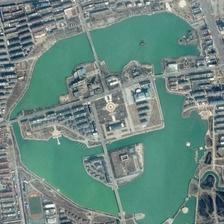
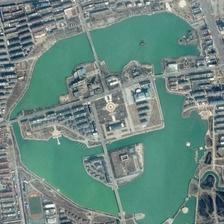
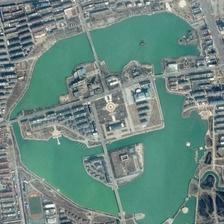
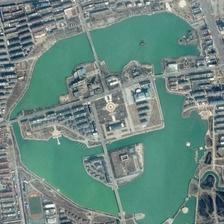
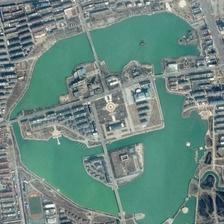
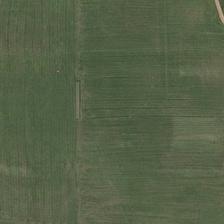
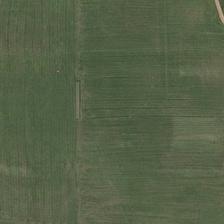
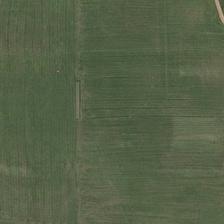
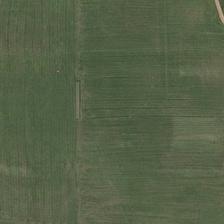
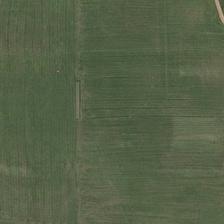
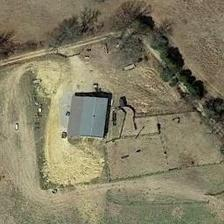
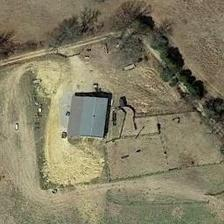
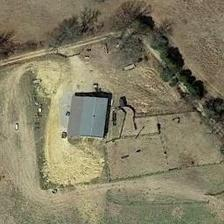
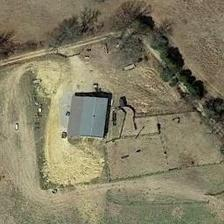
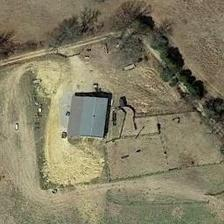
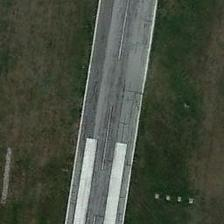
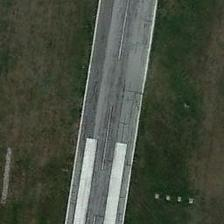
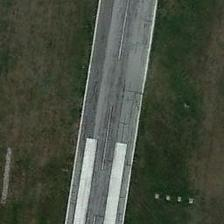
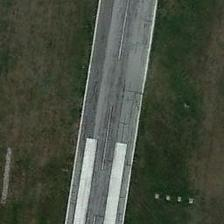
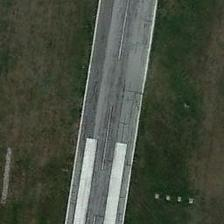
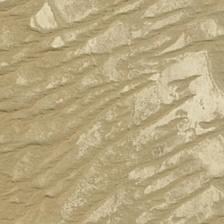
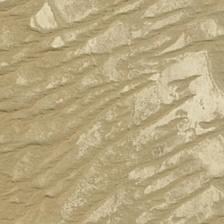
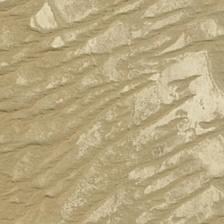
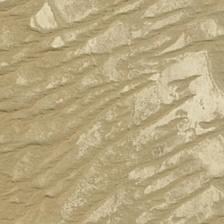
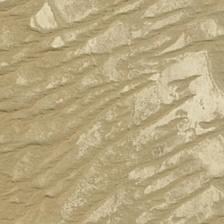
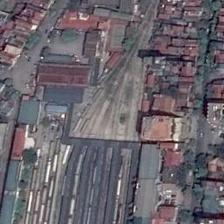
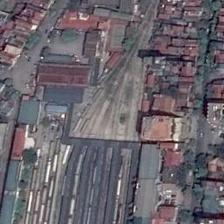
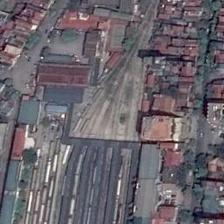
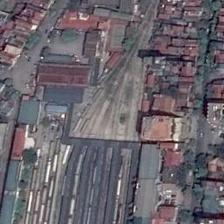
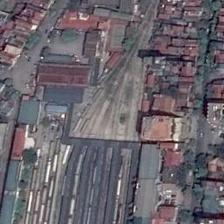
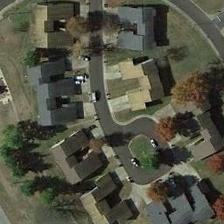
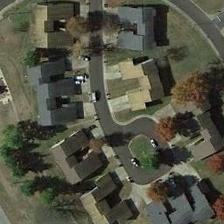
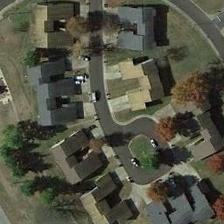
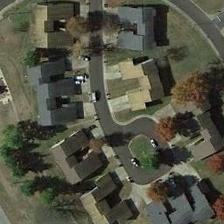
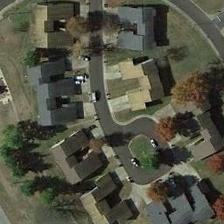
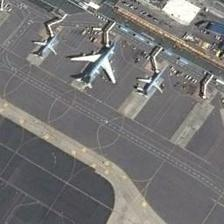
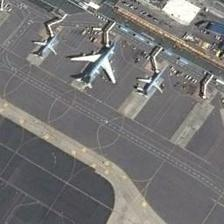
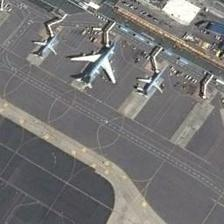
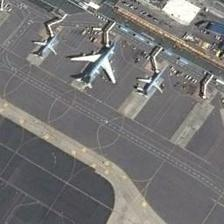
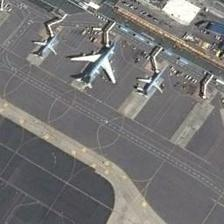

In [98]:
html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
    img = example["image"]
    # example["captions"] is a list of five strings
    for cap in example["captions"]:
        html_out += render_example(img, cap)
    # optionally a divider between images:
    html_out += "<hr style='width:100%;'>"

display(HTML("<h3>Training examples </h3>" + html_out))


In [120]:
# @title Iteraors without captions: becasue JAX gives error !

def train_data_iterator():
    """Never-ending iterator over training examples from train_ds."""
    while True:
        for image_batch, caps_batch in train_ds:
            images_np = image_batch.numpy()      # [B,H,W,3]
            caps_np   = caps_batch.numpy()       # [B,5] bytes

            for img, caps in zip(images_np, caps_np):
                # Decode all 5 captions into Python strings
                decoded_caps = [c.decode('utf-8') for c in caps]

                # Prepare the model input from the *first* caption
                suffix = decoded_caps[0].lower()
                prefix = "caption en"
                tokens, mask_ar, mask_loss, _ = preprocess_tokens(
                    prefix, suffix, SEQLEN
                )

                img_proc = img * 2.0 - 1.0
                yield {
                    "image":     img_proc,
                    "text":      np.asarray(tokens,    dtype=np.int32),
                    "mask_ar":   np.asarray(mask_ar,    dtype=np.int32),
                    "mask_loss": np.asarray(mask_loss,  dtype=np.int32),
                }


def validation_data_iterator():
    """Single-pass iterator over validation examples from val_ds."""
    for image_batch, caps_batch in val_ds:

         images_np = image_batch.numpy()
         caps_np   = caps_batch.numpy()

         for img, caps in zip(images_np, caps_np):

             prefix = "caption en"

             tokens, mask_ar, _, mask_input = preprocess_tokens(
                 prefix, seqlen=SEQLEN)
             img_proc = img * 2. - 1.
             yield {
                 "image":     img_proc,
                 "text":      np.asarray(tokens,     dtype=np.int32),
                 "mask_input": np.asarray(mask_input, dtype=np.int32),
                 "mask_ar":    np.asarray(mask_ar,    dtype=np.int32),
                 "mask_input": np.asarray(mask_input, dtype=np.int32),
             }


In [121]:
# @title Define the training step and evaluation loop.
#
# The main update_fn using simple SGD.
#
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

In [124]:
import wandb

In [126]:
os.environ["WANDB_API_KEY"]       = "cbf04bd11066e2bc23575f1baf5c4ab5a2be0403"

run  =  wandb.init(project="DI_725_Project_Phase_2__2697258", entity="DI_725___Final_Project")

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# @title Run training loop with W&B logging.
# ──────────────────────────────────────────────────────────────────────────────

%%time
import wandb
import pickle

# 1) Hyperparams
BATCH_SIZE     = 8
TRAIN_EXAMPLES = 512
LEARNING_RATE  = 0.03

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS  = max(1, TRAIN_STEPS // 4)


run.config.update({"batch_size": BATCH_SIZE,
                   "train_examples" : TRAIN_EXAMPLES,
                   "learning_rate"  : LEARNING_RATE,
                   "train_steps"    : TRAIN_STEPS,
                   "eval_steps"     : EVAL_STEPS,
                   })

# 3) Prepare data iterator & schedule
train_data_it = train_data_iterator()
sched_fn      = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS + 1,
    base=LEARNING_RATE,
    decay_type="cosine",
    warmup_percent=0.10,
)

# 4) Main loop
for step in range(1, TRAIN_STEPS + 1):
    # 4a) Fetch batch and shard
    examples = [next(train_data_it) for _ in range(BATCH_SIZE)]
    batch    = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch    = big_vision.utils.reshard(batch, data_sharding)

    # 4b) Update & get loss
    lr           = sched_fn(step)
    params, loss = update_fn(params, batch, lr)
    loss_val     = float(jax.device_get(loss))

    # 4c) Print & log scalars
    print(f"step: {step}/{TRAIN_STEPS}   lr: {lr:.5f}   loss: {loss_val:.4f}")

    wandb.log({
        "train/loss": loss_val,
        "train/lr":   lr,
    }, step=step)

    # 4d) Periodic evaluation
    if step == 1 or step % EVAL_STEPS == 0:
        print(f"Model predictions at step {step}")
        # collect a few samples
        samples = make_predictions(
            validation_data_iterator(),
            num_examples=4,
            batch_size=4
        )
        # build W&B images
        wb_images = []
        html_out  = ""
        for img, caption in samples:
            # convert from [-1,1] float32 → uint8
            img_uint8 = ((img + 1.0) * 127.5).astype(np.uint8)
            wb_images.append(
                wandb.Image(img_uint8, caption=caption)
            )
            html_out += render_example(img, caption)

        # display in Colab
        display(HTML(html_out))

        # log to W&B
        wandb.log({"eval/samples": wb_images}, step=step)

# 5) Save final parameters
with open("params_final.pkl", "wb") as f:
    pickle.dump(params, f)
wandb.save("params_final.pkl")

wandb.finish()


step: 1/64   lr: 0.00500   loss: 1.9575
Model predictions at step 1


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  WANDB </h2>
</div>

In [ ]:
print(os.getcwd())

/content


In [ ]:
os.environ["WANDB_NOTEBOOK_NAME"] = "DI_725_Project_Phase_2__2697258.ipynb"

In [ ]:
os.environ["WANDB_NOTEBOOK_NAME"] = "DI_725_Project_Phase_2__2697258.ipynb"
os.environ["WANDB_API_KEY"]       = "cbf04bd11066e2bc23575f1baf5c4ab5a2be0403"

run  =  wandb.init(project="DI_725_Project_Phase_2__2697258", entity="DI_725___Final_Project")

In [ ]:
run  =  wandb.init(project="DI_725_Project_Phase_2__2697258", entity="DI_725___Final_Project")

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find DI_725_Project_Phase_2__2697258.ipynb.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: turgay-yildiz-phi-e-pi (DI_725___Final_Project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


images[0]

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Exploratory Data Analysis (EDA)  </h2>
</div>


data["split"]

In [ ]:
split_series = data['split']
counts       = split_series.value_counts()

print(counts)

split
train    35614
test      4454
val       4453
Name: count, dtype: int64


In [ ]:
num_train = counts.get('train', 0)
num_test  = counts.get('test', 0)
num_val   = counts.get('val', 0)

print("Number of train samples:", num_train)
print("Number of test samples:", num_test)
print("Number of val samples:", num_val)

Number of train samples: 35614
Number of test samples: 4454
Number of val samples: 4453


###  1-) Check for Missing Values :

In [ ]:
if 1:

    print(data.isnull().sum())

source       0
split        0
image        0
caption_1    0
caption_2    0
caption_3    0
caption_4    0
caption_5    0
dtype: int64


### 2-) Statistical Summary :

In [ ]:
data.describe(include='all')

,source,split,image,caption_1,caption_2,caption_3,caption_4,caption_5
count,44521,44521,44521,44521,44521,44521,44521,44521
unique,3,3,44521,22503,14838,16113,12775,18289
top,NWPU,train,NWPU_31430.jpg,This meadow has different sparsity in differen...,The entire image is dominated by grass .,The snow berg is consist of bare land and whit...,The meadow is dense but uneven .,The grass is beside the beach .
freq,31500,35614,1,130,435,448,288,232


In [ ]:
data.describe(include='all').loc['top']

source                                                    NWPU
split                                                    train
image                                           NWPU_31430.jpg
caption_1    This meadow has different sparsity in differen...
caption_2             The entire image is dominated by grass .
caption_3    The snow berg is consist of bare land and whit...
caption_4                     The meadow is dense but uneven .
caption_5                      The grass is beside the beach .
Name: top, dtype: object

In [ ]:
data.describe(include='all').loc['top']["caption_5"]

'The grass is beside the beach .'

In [ ]:
total_images     = len(data)
captions_per_img = 5
total_captions   = total_images * captions_per_img
print(f"Total captions: {total_captions}")

Total captions: 222605


In [ ]:
all_captions = []

for i in range(1, 6):
    all_captions.extend(data[f'caption_{i}'].tolist())

# Tokenize and compute word counts
caption_lengths = [len(word_tokenize(caption)) for caption in all_captions]



min_len   = np.min(caption_lengths)
max_len   = np.max(caption_lengths)
mean_len  = np.mean(caption_lengths)
median_len= np.median(caption_lengths)

print(f"Min: {min_len}, Max: {max_len}, Mean: {mean_len:.2f}, Median: {median_len}")

Min: 5, Max: 51, Mean: 12.19, Median: 11.0


In [ ]:
from collections import Counter
import string

In [ ]:
# Build list of all words
all_tokens = []
for caption in all_captions:
    tokens = word_tokenize(caption.lower())
    tokens = [word for word in tokens if word.isalpha()]  # remove punctuation/numbers
    all_tokens.extend(tokens)

# Vocabulary size
vocab_size = len(set(all_tokens))
print(f"Vocabulary size: {vocab_size}")

# Top 20 words
word_counts = Counter(all_tokens)
top_20_words = word_counts.most_common(20)
print("Top 20 words:")
for word, freq in top_20_words:
    print(f"{word}: {freq}")

Vocabulary size: 3565
Top 20 words:
the: 205467
a: 117753
are: 110828
and: 100622
is: 77975
there: 73976
of: 69650
some: 62091
many: 61774
green: 61300
on: 55452
in: 54672
trees: 51503
buildings: 47186
with: 43122
to: 26743
next: 24675
area: 24371
by: 21303
two: 18839


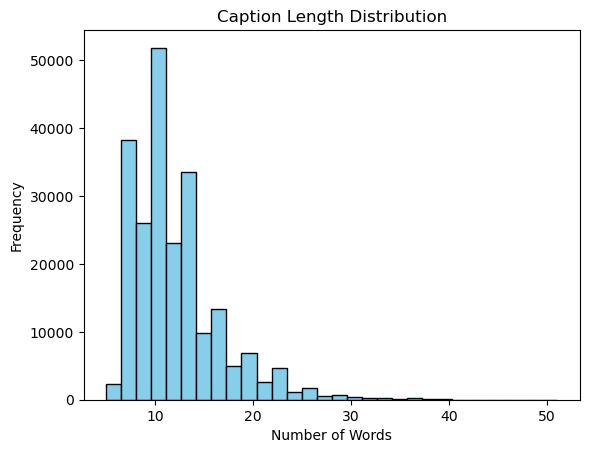

In [ ]:
plt.hist(caption_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Caption Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Dataset :   </h2>
</div>


In [ ]:
model_id   = "google/paligemma-3b-mix-224"
processor  = AutoProcessor.from_pretrained(model_id, use_fast=True)

In [ ]:
class RSICDDataset(Dataset):
    def __init__(self, dataframe, processor, transform=None):
        self.dataframe  = dataframe
        self.images_dir = '/content/drive/MyDrive/extracted_folder/resized/'
        self.transform  = transform
        self.processor  = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row       = self.dataframe.iloc[idx]
        img_path  = f"{self.images_dir}/{row['image']}"
        image     = Image.open(img_path).convert('RGB')

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)


        image    =   np.array(image).astype(np.float32)  # Convert to float32

        captions = row[3:].tolist()

        # Add <image> tokens to the text (for each image)
        caps = [f"<image> {caption}" for caption in captions]




        return image,   caps

In [ ]:
train_data = data[data['split'] == 'train'].reset_index(drop=True)
val_data   = data[data['split'] == 'val'].reset_index(drop=True)
test_data  = data[data['split'] == 'test'].reset_index(drop=True)

In [ ]:
train_dataset    =   RSICDDataset(train_data, processor, transform=None)
val_dataset      =   RSICDDataset(val_data, processor, transform=None)
test_dataset     =   RSICDDataset(test_data, processor, transform=None)

In [ ]:
len(train_dataset), len(val_dataset),  len(test_dataset)

(35614, 4453, 4454)

In [ ]:
train_loader    =   DataLoader(train_dataset, batch_size=8,    pin_memory = True,    shuffle=True)
val_loader      =   DataLoader(val_dataset,   batch_size=8,    pin_memory = True,    shuffle=True)
test_loader     =   DataLoader(test_dataset,   batch_size=8,   pin_memory = True,    shuffle=True)

In [ ]:
for image , out in train_loader:
    break

In [ ]:
#imgs  =  out["image"]
caps  =  out["captions"]

In [ ]:
imgs.shape,   np.shape(caps)

(torch.Size([8, 224, 224, 3]), (5, 8))

In [ ]:
imgs.min(),   imgs.max()

(tensor(-1.), tensor(1.))

In [ ]:
num  =  0

In [ ]:
img_tensor = imgs[num]

# Rescale from [-1, 1] → [0, 255]
img_tensor = ((img_tensor + 1) / 2.0) * 255.0

# Convert to uint8
img_tensor = img_tensor.clamp(0, 255).byte()

# Rearrange shape to (H, W, 3) for imshow
img_np = img_tensor.permute(1, 2, 0).cpu().numpy()

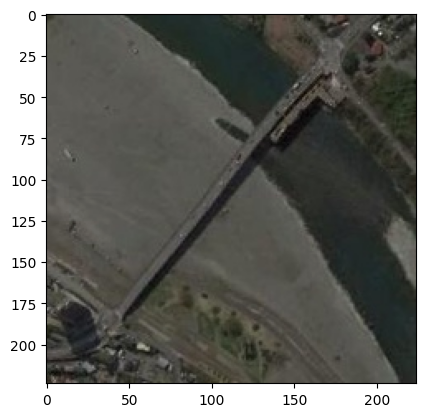

In [ ]:
plt.imshow(  img_np  )

In [ ]:
tokens  =  []

for i in range(5):
  temp  =  []
  for j in range(320):

    token  =  processor.decode(caps[num][i][j].item(),  skip_special_tokens=True)

    if len(token) != 0:

      temp.append(token)

  sentence = " ".join(temp)
  tokens.append(sentence)

In [ ]:
tokens

[' A  bridge  built  on  a  dark  green  river  and  the  flood  bed  of  the  river  while  some  green  plants  on  one  side  of  the  river  . \n',
 ' Most  of  the  area  the  bridge  crosses  is  bare  land  . \n',
 ' A  bridge  connects  the  land  on  both  sides  of  the  turquoise  water    There  are  many  buildings  on  the  land    There  are  many  cars  on  the  bridge  . \n',
 ' There  is  a  bridge  over  the  water  and  land  . \n',
 ' Lots  of  green  plants  are  around  the  bridge  . \n']

In [ ]:
256 * 256* 256

16777216

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:10px;">
<h2>  Model </h2>
</div>


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from accelerate import Accelerator

In [ ]:
accelerator = Accelerator()
device      = accelerator.device

In [ ]:
model_id   =    "google/paligemma-3b-mix-224"
device     =    "cuda:0"
dtype      =    torch.bfloat16

In [ ]:
model = PaliGemmaForConditionalGeneration.from_pretrained(
                                                            model_id,
                                                            torch_dtype  =   dtype,
                                                            device_map   =   "auto",
                                                            revision     =   "bfloat16",
                                                            low_cpu_mem_usage=True
                                                        )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
processor = AutoProcessor.from_pretrained(model_id, use_fast=True)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [ ]:
train_loader, model, optimizer = accelerator.prepare(train_loader, model, optimizer)

In [ ]:
for data in train_loader:
  print(data["image"].shape)
  print(len(data["captions"]))
  break

torch.Size([8, 224, 224, 3])
5


In [ ]:
for batch in train_loader:
    # batch["raw_images"]  = list of PIL.Image
    # batch["raw_texts"]   = list of caption strings (e.g. "<image> caption")

    # 1) Call the processor once for the batch:
    model_inputs = processor(
        text=batch["raw_texts"],
        images=batch["raw_images"],
        padding="longest",
        truncation=True,
        max_length=64,
        return_tensors="pt"
    ).to(device)

    # 2) Clone input_ids for labels
    labels = model_inputs.input_ids.clone()

    optimizer.zero_grad()
    with autocast(device_type=device_type):
        outputs = model(
            **model_inputs,   # contains pixel_values, input_ids, attention_mask
            labels=labels     # tells it to compute the seq2seq loss
        )
        loss = outputs.loss

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()


ValueError: Number of images does not match number of special image tokens in the input text. Got tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0') image tokens in the text but 2048 tokens from image embeddings.

In [ ]:
train_losses, val_losses = train_val_loop(     num_epochs=5,     train_loader=train_loader,     val_loader=val_loader,     patience=2 )


KeyError: 'captions'

In [ ]:
optimizer       =   AdamW(model.parameters(), lr=learning_rate, weight_decay=0.0)
criterion_bce   =   nn.BCEWithLogitsLoss()
criterion_l1    =   nn.L1Loss()

run.log({"LRate": learning_rate})

scheduler       =   torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.8)
scaler          =   GradScaler()

In [ ]:
train(num_epochs=25, patience=10, counter=0, best_loss=best_loss)

100%|██████████| 844/844 [11:18<00:00,  1.24it/s]


-------------------------------------------------------------------------------
|  Epoch [1/25]          |        Total Train LOSS : 0.1604           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [1/25]          |        Total Train BBOX : 0.1386           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [1/25]          |        Total Train CLS  : 0.0267           |
-------------------------------------------------------------------------------


Epoch 1/25: 100%|██████████| 94/94 [00:48<00:00,  1.95it/s]


-------------------------------------------------------------------------------
|  Epoch [1/25]         |       Total Validation LOSS : 0.1462           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [1/25]         |       Total Validation BBOX : 0.1403           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [1/25]         |       Total Validation CLS : 0.0319           |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 844/844 [06:13<00:00,  2.26it/s]


-------------------------------------------------------------------------------
|  Epoch [2/25]          |        Total Train LOSS : 0.1449           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [2/25]          |        Total Train BBOX : 0.1131           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [2/25]          |        Total Train CLS  : 0.0220           |
-------------------------------------------------------------------------------


Epoch 2/25: 100%|██████████| 94/94 [00:17<00:00,  5.46it/s]


-------------------------------------------------------------------------------
|  Epoch [2/25]         |       Total Validation LOSS : 0.1454           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [2/25]         |       Total Validation BBOX : 0.1262           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [2/25]         |       Total Validation CLS : 0.0262           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   0.55                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 844/844 [05:31<00:00,  2.54it/s]


-------------------------------------------------------------------------------
|  Epoch [3/25]          |        Total Train LOSS : 0.1442           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [3/25]          |        Total Train BBOX : 0.1339           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [3/25]          |        Total Train CLS  : 0.0271           |
-------------------------------------------------------------------------------


Epoch 3/25: 100%|██████████| 94/94 [00:17<00:00,  5.51it/s]


-------------------------------------------------------------------------------
|  Epoch [3/25]         |       Total Validation LOSS : 0.1445           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [3/25]         |       Total Validation BBOX : 0.0977           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [3/25]         |       Total Validation CLS : 0.0178           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   0.59                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 844/844 [05:32<00:00,  2.54it/s]


-------------------------------------------------------------------------------
|  Epoch [4/25]          |        Total Train LOSS : 0.1438           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [4/25]          |        Total Train BBOX : 0.1390           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [4/25]          |        Total Train CLS  : 0.0213           |
-------------------------------------------------------------------------------


Epoch 4/25: 100%|██████████| 94/94 [00:16<00:00,  5.64it/s]


-------------------------------------------------------------------------------
|  Epoch [4/25]         |       Total Validation LOSS : 0.1444           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [4/25]         |       Total Validation BBOX : 0.0927           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [4/25]         |       Total Validation CLS : 0.0143           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   0.08                               |
-------------------------------------------------------------------------------
*************...saving best model *************


 27%|██▋       | 232/844 [01:33<04:06,  2.48it/s]


KeyboardInterrupt: 

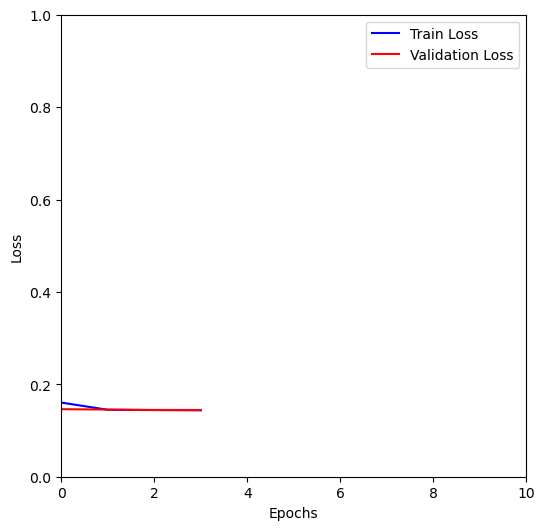

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.plot(train_loss, "b-", label="Train Loss")
ax.plot(val_loss, "r-", label="Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

ax.set_xlim([0, 10])
ax.set_ylim([0,1])

ax.legend()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Results : </h2>
</div>

In [ ]:
e  =  model.eval()

In [ ]:
for imgs, bbox, clas in train_loader:
    break

In [ ]:
imgs.shape

torch.Size([32, 3, 360, 640])

In [ ]:
bbox.shape

torch.Size([32, 60, 4])

In [ ]:
num  =  7

In [ ]:
with torch.no_grad():

    img            =     (imgs).to(device)

    p_box, clas          =     model(img)



In [ ]:
p_box[0][:5]

tensor([[3.8835e-01, 5.1563e-01, 9.6944e-02, 6.4924e-02],
        [1.9195e-01, 3.1988e-01, 4.6286e-02, 4.4849e-02],
        [3.1621e-03, 7.0171e-04, 8.4361e-03, 8.0962e-03],
        [1.4171e-05, 1.0747e-05, 1.7187e-05, 8.2831e-06],
        [1.7239e-05, 8.4760e-06, 1.3381e-05, 1.8683e-05]], device='cuda:0')

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Evaluation Metrices</h2>
</div>

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Sync for WANDB</h2>
</div>

In [ ]:
#run.finish()